<a href="https://colab.research.google.com/github/iongie/demo-day-fin-8/blob/main/_Demo_day_Fintech_8_with_socioeconomy_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demo day Fintech 8

"Data tersebut terkait dengan kampanye pemasaran langsung dari lembaga perbankan Portugis. Kampanye pemasaran didasarkan pada panggilan telepon. Seringkali, lebih dari satu kontak ke klien yang sama diperlukan, untuk mengakses apakah produk (deposito berjangka bank) akan ('ya') atau tidak ('tidak') dilanggan oleh pelanggan atau tidak. Folder data berisi dua kumpulan data: -

     train.csv: 45.211 baris dan 18 kolom diurutkan berdasarkan tanggal (dari Mei 2008 hingga November 2010)
     test.csv: 4521 baris dan 18 kolom dengan 10% contoh (4521), dipilih secara acak dari train.csv"

test pull and push

##Setup

In [ ]:
import pathlib
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from google.colab import data_table
import tensorflow as tf
from sklearn.metrics import confusion_matrix

##Function

function split data

In [ ]:
def dataframe_split(data, ratio= 0.2, shuffle= 0):
  len_ = int(len(data) - (ratio*len(data)))
  if shuffle == 0 :
    part_  = data.iloc[:int(1 + len_)]
    rest_part_ = data.drop(part_.index)
  elif shuffle == 1:
    part_ = data.sample(frac = 1.0 - ratio)
    rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

fucntion membuat dataset

In [ ]:
def dataframe_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
def dataframe_imbalance_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  data = tf.data.Dataset.from_tensor_slices((dict(df), labels)).batch(batch_size)

  no_ds = (data
          .unbatch()
          .filter(lambda features, label: label==0)
          .repeat())
  yes_ds = (data
            .unbatch()
            .filter(lambda features, label: label==1)
            .repeat())
  
  ds = tf.data.Dataset.sample_from_datasets([no_ds, yes_ds], weights=[0.5, 0.5], stop_on_empty_dataset=True)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

function preprocessing numeric

In [ ]:
def numeric_preprocessing(name, dataset, step):
  feature_dataset = dataset.map(lambda x,y: x[name])
  layer = tf.keras.layers.Normalization()
  layer.adapt(feature_dataset, steps=step)

  return layer

fucntion preprocessing categories

In [ ]:
def categories_preprocessing(name, dataset, dtype, step):
  if(dtype == "int64"):
    lookup = tf.keras.layers.IntegerLookup()
  else:
    lookup = tf.keras.layers.StringLookup()
  feature_dataset = dataset.map(lambda x,y: x[name])
  lookup.adapt(feature_dataset, steps=step)

  # return lookup
  category_encoding = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  return lambda feature:  category_encoding(lookup(feature))

plot metric

In [ ]:
def plot_metric(x, y, history, metric):
  fig, ax = plt.subplots(x, y, figsize=(15,10))
  epochs = range(len(history.history[metric[0]]))
  for metric, ax in zip(metric, ax.flatten()):
    ax.plot(epochs, history.history[metric], 'r', label='train')
    ax.plot(epochs, history.history['val_'+metric], 'b', ls="--", label='val')
    ax.set_ylabel(metric)
    ax.set_xlabel('epoch')
    ax.legend()  
  plt.show()

plot confution matrix

In [ ]:
def plot_confution_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Tidak berlangganan diprediksi tidak berlangganan (True Negatives): ', cm[0][0])
  print('Tidak berlangganan diprediksi berlangganan (False Positives): ', cm[0][1])
  print('Berlangganan diprediksi tidak berlangganan (False Negatives): ', cm[1][0])
  print('Berlangganan diprediksi berlangganan (True Positives): ', cm[1][1])
  print('Total: ', np.sum(cm[1]))

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [ ]:
data_url = "/content/drive/MyDrive/Kumpulan_dataset/fintech_banking_dataset.zip"
data_dir = zipfile.ZipFile(data_url, 'r')
data_dir.extractall("demoday")
data_dir.close()

In [ ]:
dataset_train=pd.read_csv('demoday/train.csv', delimiter=";")
dataset_test=pd.read_csv('demoday/test.csv', delimiter=";")

In [ ]:
# dataset_train=pd.read_csv('train.csv', delimiter=";")
# dataset_test=pd.read_csv('test.csv', delimiter=";")
# dataset_additional=pd.read_csv('bank-additional.csv', delimiter=";")
# dataset_additional_full=pd.read_csv('bank-additional-full.csv', delimiter=";")
# dataset_bank=pd.read_csv('bank.csv', delimiter=";")
# dataset_bank_full=pd.read_csv('bank_full.csv', delimiter=";")

In [ ]:
dataset_train=pd.read_csv('bank-additional-full.csv', delimiter=";")
dataset_test=pd.read_csv('bank-additional.csv', delimiter=";")

In [ ]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

##Deskripsi dataset
###Input variables:
bank client data:  
1 - age : umur pelanggan (numeric)  
2 - job : jenis pekerjaan (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : status pernikahan (categorical: 'divorced','married','single','unknown'; note: 'divorced' berarti cerai atau janda)  
4 - education : tingkat pendidikan(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: apakah memiliki kredit yang gagal bayar? (categorical: 'no','yes','unknown')  
6 - housing: apakah memiliki pinjaman untuk rumah? (categorical: 'no','yes','unknown')  
7 - loan: apakah memiliki pinjaman untuk pribadi? (categorical: 'no','yes','unknown')  
related with the last contact of the current campaign:  
8 - contact: jenis komunikasi kontak (categorical: 'cellular','telephone')  
9 - month: kontak terakhir bulan tahun (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: hari kontak terakhir dalam seminggu (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: durasi kontak terakhir, dalam detik (numeric)  
other attributes:  
12 - campaign: jumlah kontak yang dilakukan selama kampanye ini dan untuk klien ini (numeric, includes last contact)  
13 - pdays: jumlah hari yang berlalu setelah klien terakhir dihubungi dari kampanye sebelumnya (numeric; 999 artinya klien sebelumnya tidak dihubungi)  
14 - previous: jumlah kontak yang dilakukan sebelum kampanye ini dan untuk klien ini (numeric)  
15 - poutcome: hasil dari kampanye pemasaran sebelumnya (categorical: 'failure','nonexistent','success')  

###Output variable (desired target):
21 - y - apakah klien telah berlangganan deposito berjangka?? (binary: 'yes','no')  
Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing  

##Data Explorer

In [ ]:
print(f"jumlah data untuk train adalah {len(dataset_train)}")
print(f"jumlah data untuk test adalah {len(dataset_test)}")

jumlah data untuk train adalah 41188
jumlah data untuk test adalah 4119


In [ ]:
dataset_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
dataset_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


melihat type pada data set

In [ ]:
dataset_train.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

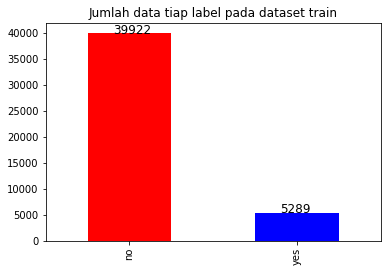

In [ ]:
ax = dataset_train['y'].value_counts().plot.bar(color=['r','b'])
plt.title("Jumlah data tiap label pada dataset train")
for p in ax.patches:
    b = p.get_bbox()
    ax.annotate(str(p.get_height()), ((b.x0 + b.x1)/2 - .1, p.get_height() * 1.),fontsize=12)

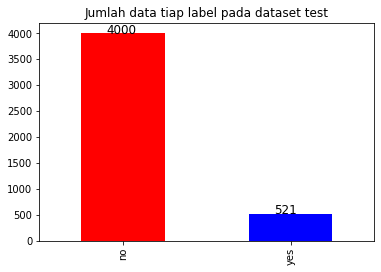

In [ ]:
ax = dataset_test['y'].value_counts().plot.bar(color=['r','b'])
plt.title("Jumlah data tiap label pada dataset test")
for p in ax.patches:
    b = p.get_bbox()
    ax.annotate(str(p.get_height()), ((b.x0 + b.x1)/2 - .1, p.get_height() * 1.),fontsize=12)

In [ ]:
train_index = [i for i in dataset_train.drop(columns=['y']).columns]
dataset_train.groupby(by=train_index)["y"].value_counts().unstack().reset_index().sort_values(by=["no"], ascending=True).head()

y,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,no,yes
2,18,student,single,primary,no,1944,no,no,telephone,10,aug,122,3,-1,0,unknown,1.0,NaN
30043,45,entrepreneur,married,primary,no,1953,yes,no,unknown,15,may,95,3,-1,0,unknown,1.0,NaN
30044,45,entrepreneur,married,primary,no,2418,yes,no,unknown,14,may,120,1,-1,0,unknown,1.0,NaN
30045,45,entrepreneur,married,primary,no,5315,yes,yes,cellular,15,may,262,2,-1,0,unknown,1.0,NaN
30046,45,entrepreneur,married,secondary,no,-479,yes,no,cellular,30,jul,167,2,-1,0,unknown,1.0,NaN


In [ ]:
cek_no_yes_max = dataset_train.groupby(by=["age", "job", "marital", "education", "balance", "housing", "loan", "month" , "duration"])["y"].value_counts().unstack().reset_index()

In [ ]:
cek_no_yes_max.loc[cek_no_yes_max['no'].ge(1.0) &cek_no_yes_max['yes'].ge(1.0)]

y,age,job,marital,education,balance,housing,loan,month,duration,no,yes


##Data Preparation

mengubah column y, dengan nilai 0 menunjukan *NO* dan nilai 1 menunjukan *YES*

In [ ]:
dataset_train['target'] = dataset_train.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

dataset_train.drop(columns=["default", "contact",	"day_of_week", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)

In [ ]:
dataset_test['target'] = dataset_test.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

dataset_test.drop(columns=["default", "contact",	"day_of_week", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)

dataset train ini merupakan dataframe pandas, split data train dengan ratio 80:20 . 20 % untuk validasi

In [ ]:
train, val = dataframe_split(dataset_train, ratio = 0.2, shuffle=1)

In [ ]:
print(len(train), 'training examples')
print(len(val), 'validation examples')

32950 training examples
8238 validation examples


##Data Preprocessing

membuat dataset

In [ ]:
batch_size = 1024
step = 128

train_ds = dataframe_imbalance_to_dataset(train, batch_size=batch_size)
val_ds = dataframe_imbalance_to_dataset(val, batch_size=batch_size)
test_ds = dataframe_to_dataset(dataset_test, batch_size=batch_size)

cek data

In [ ]:
for features, labels in train_ds.take(1):
  print(labels.numpy())

[1 0 1 ... 0 1 1]


In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of marital:', train_features['job'])
print('A batch of targets:', label_batch )

Every feature: ['age', 'job', 'marital', 'education', 'housing', 'loan', 'month', 'duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
A batch of marital: tf.Tensor(
[[b'unknown']
 [b'blue-collar']
 [b'retired']
 ...
 [b'technician']
 [b'services']
 [b'management']], shape=(1024, 1), dtype=string)
A batch of targets: tf.Tensor([0 1 0 ... 1 0 1], shape=(1024,), dtype=int64)


In [ ]:
test_job_col = train_features['job']
test_job_layer = categories_preprocessing(name='job',
                                        dataset=train_ds,
                                        dtype='string',
                                        step=step)
test_job_layer(test_job_col).numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
test_duration_col = train_features['duration']
test_duration_layer = numeric_preprocessing(name='duration',
                                            dataset=train_ds,
                                            step=step)
test_duration_layer(test_duration_col)

<tf.Tensor: shape=(1024, 1), dtype=float32, numpy=
array([[-0.27201688],
       [-0.48858696],
       [-0.60257125],
       ...,
       [-1.0271626 ],
       [ 0.92766744],
       [-0.42304602]], dtype=float32)>

membagikan column berdasarkan numeric atau categorical integer atau string

In [ ]:
# numeric_keys = ["balance", "duration"]
numeric_keys = ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
categorical_integer_keys = ["age"]
categorical_string_keys = ["job", "marital", "education", "housing", "loan", "month"]
all_inputs = []
all_preprocessors = []

In [ ]:
for numeric in numeric_keys:
  input = tf.keras.Input(shape=(1,), name=numeric, dtype="int64")
  num_layer = numeric_preprocessing(name=numeric, dataset=train_ds, step=step)
  num_preprocessor = num_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(num_preprocessor)

In [ ]:
for categorical in categorical_string_keys:
  input = tf.keras.Input(shape=(1,), name=categorical, dtype="string")
  cat_layer = categories_preprocessing(name=categorical, dataset=train_ds, dtype="string", step=step)
  cat_preprocessor = cat_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_preprocessor)

In [ ]:
for categorical_int in categorical_integer_keys:
  input = tf.keras.Input(shape=(1,), name=categorical_int, dtype="int64")
  cat_int_layer = categories_preprocessing(name=categorical_int, dataset=train_ds, dtype="int64", step=step)
  cat_int_preprocessor = cat_int_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_int_preprocessor)

In [ ]:
all_inputs, all_preprocessors

([<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'duration')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'emp.var.rate')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'cons.price.idx')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'cons.conf.idx')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'euribor3m')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'nr.employed')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'job')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'marital')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'education')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'housing')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'loan')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'month')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'age')>],
 [<K

##Model

In [ ]:
all_features = tf.keras.layers.concatenate(all_preprocessors)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(all_inputs, output)

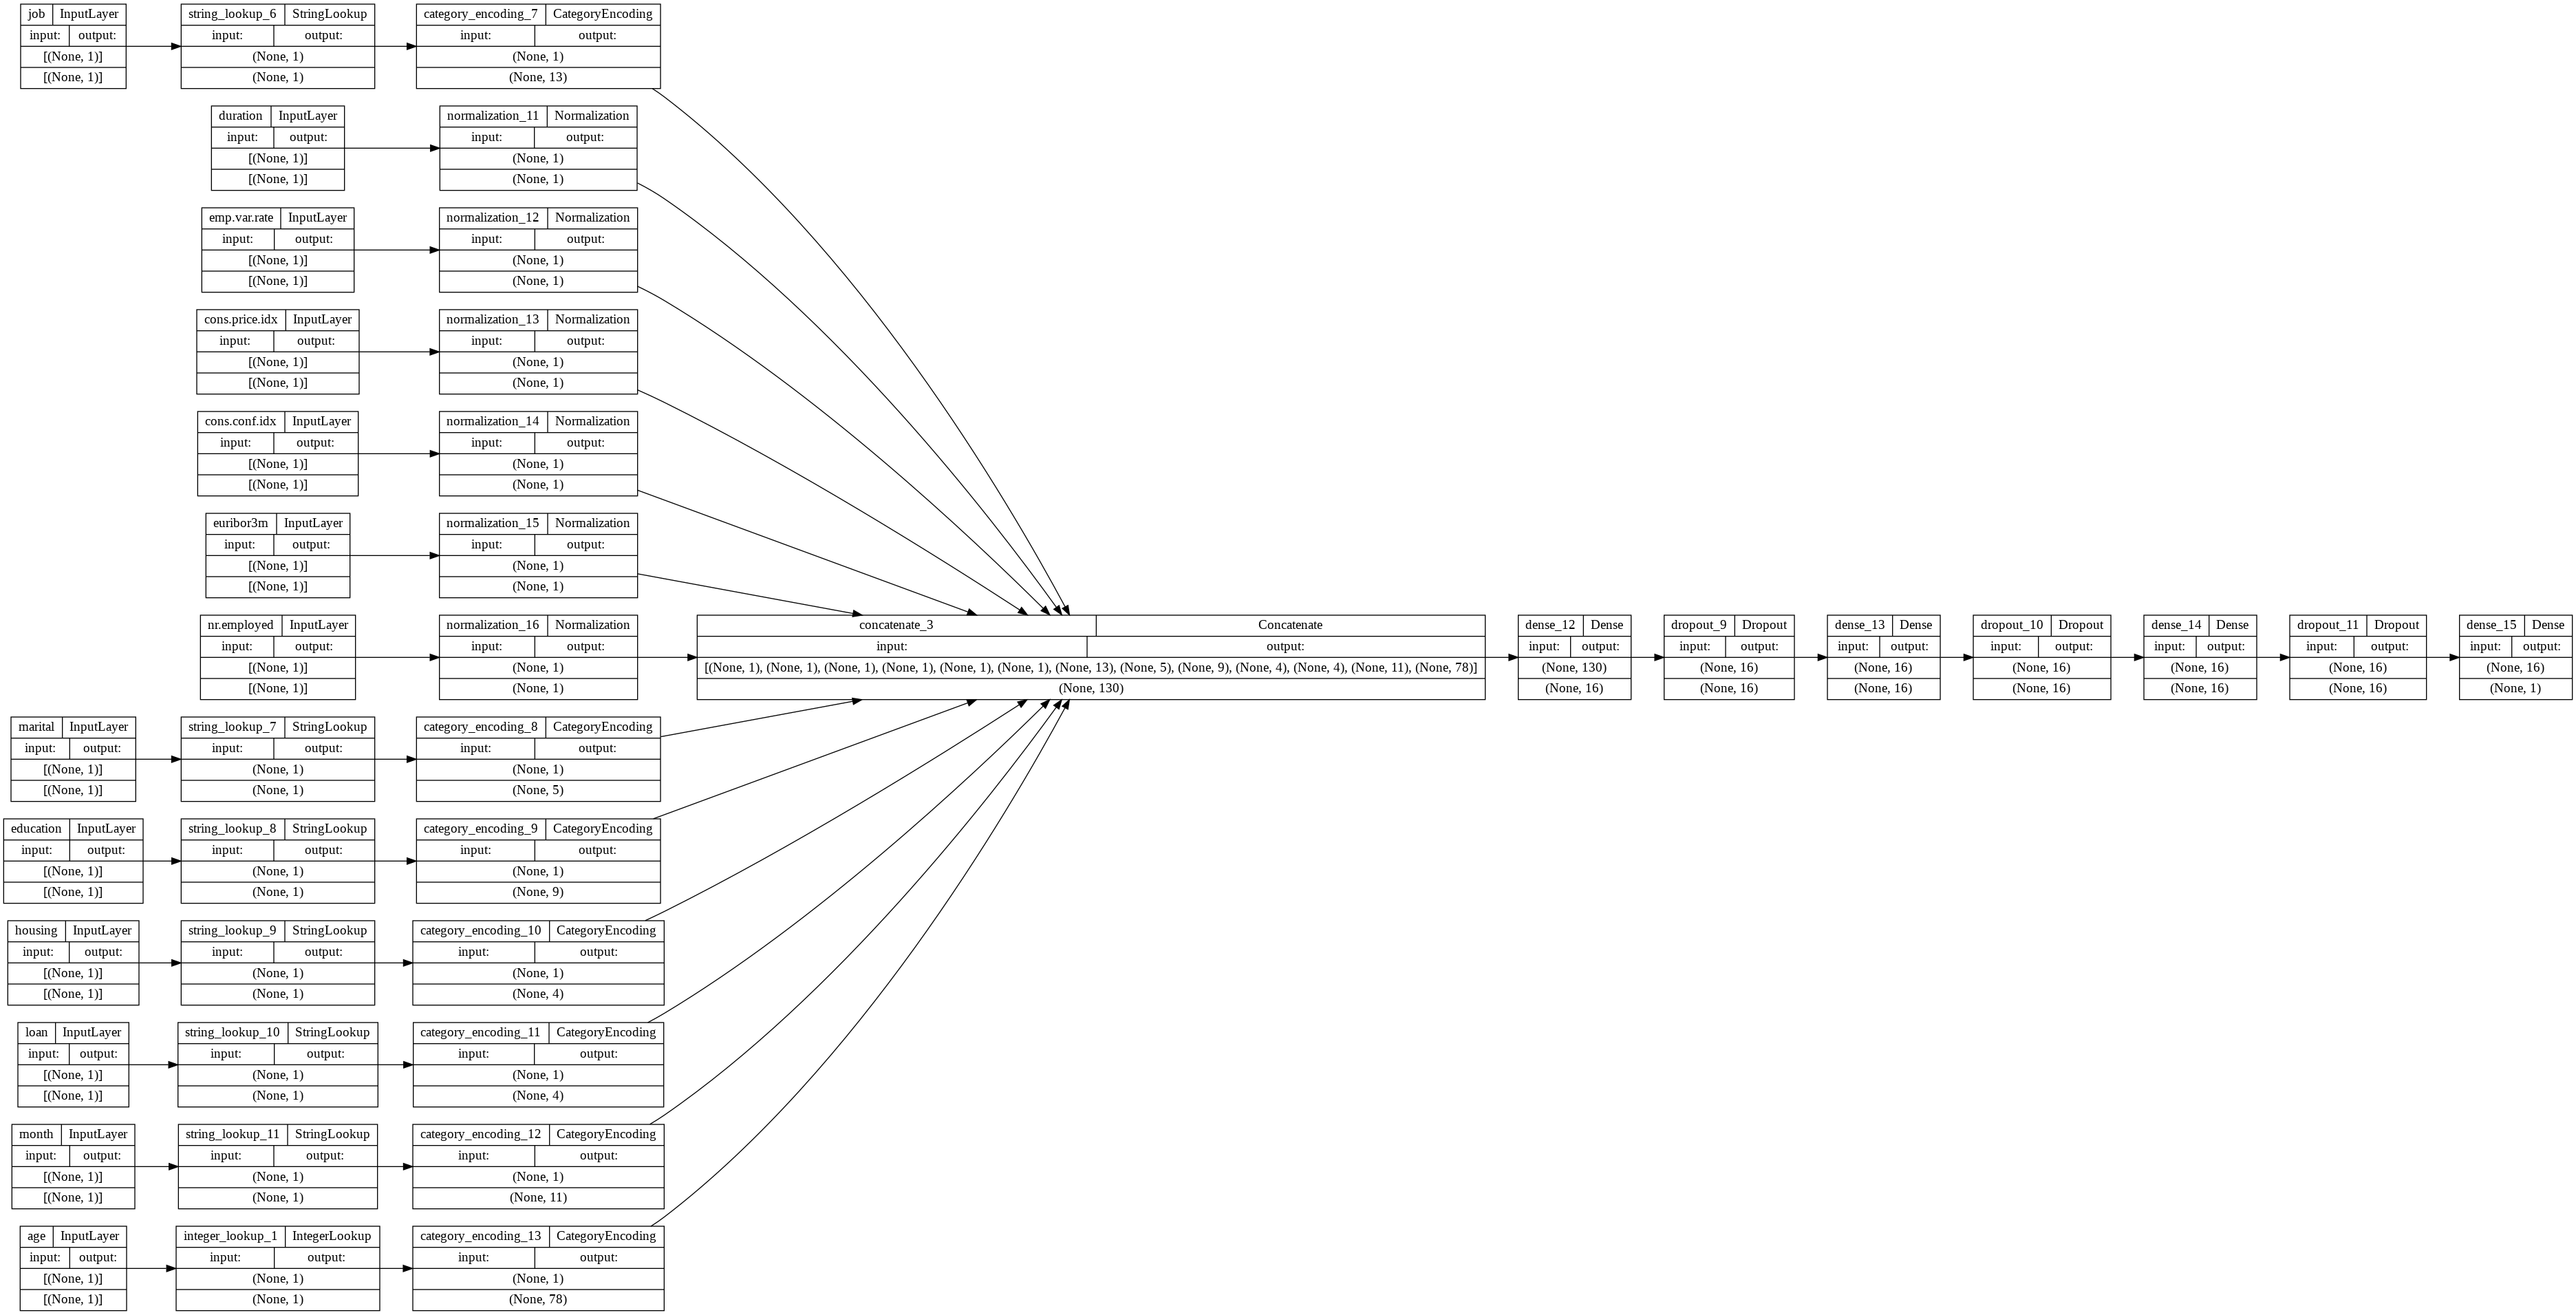

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, epochs=100, validation_data=val_ds, validation_steps=32, callbacks=[loss, val_loss], steps_per_epoch=32)

Epoch 1/100
32/32 [==============================] - 16s 436ms/step - loss: 0.6825 - tp: 9834.0000 - fp: 8218.0000 - tn: 8077.0000 - fn: 6639.0000 - accuracy: 0.5466 - precision: 0.5448 - recall: 0.5970 - val_loss: 0.6507 - val_tp: 12527.0000 - val_fp: 3127.0000 - val_tn: 13190.0000 - val_fn: 3924.0000 - val_accuracy: 0.7848 - val_precision: 0.8002 - val_recall: 0.7615
Epoch 2/100
32/32 [==============================] - 13s 413ms/step - loss: 0.6434 - tp: 11088.0000 - fp: 7308.0000 - tn: 9077.0000 - fn: 5295.0000 - accuracy: 0.6154 - precision: 0.6027 - recall: 0.6768 - val_loss: 0.5606 - val_tp: 13228.0000 - val_fp: 3059.0000 - val_tn: 13439.0000 - val_fn: 3042.0000 - val_accuracy: 0.8138 - val_precision: 0.8122 - val_recall: 0.8130
Epoch 3/100
32/32 [==============================] - 13s 419ms/step - loss: 0.5922 - tp: 11529.0000 - fp: 5450.0000 - tn: 10929.0000 - fn: 4860.0000 - accuracy: 0.6854 - precision: 0.6790 - recall: 0.7035 - val_loss: 0.4752 - val_tp: 13814.0000 - val_fp: 

##Model Evaluation

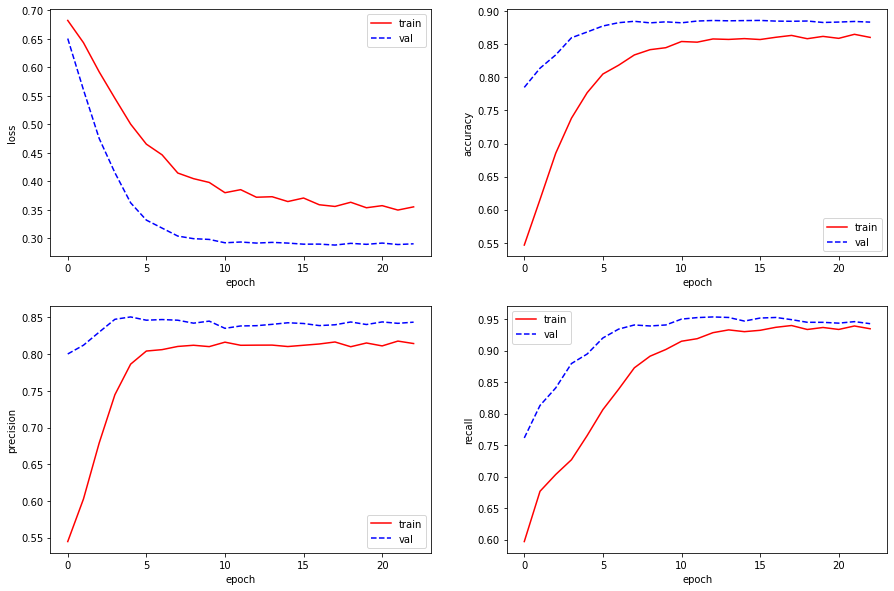

In [ ]:
metric = ['loss', 'accuracy', 'precision', 'recall']
plot_metric(2,2, history, metric)

In [ ]:
predict_test = model.predict(test_ds)
test_ds_unbach = test_ds.unbatch()
label_test = [i[1] for i in list(test_ds_unbach.as_numpy_iterator())]

5/5 [==============================] - 0s 12ms/step - loss: 0.3227 - tp: 436.0000 - fp: 712.0000 - tn: 2956.0000 - fn: 15.0000 - accuracy: 0.8235 - precision: 0.3798 - recall: 0.9667
loss :  0.322672575712204
tp :  436.0
fp :  712.0
tn :  2956.0
fn :  15.0
accuracy :  0.8235008716583252
precision :  0.37979093194007874
recall :  0.9667405486106873
Tidak berlangganan diprediksi tidak berlangganan (True Negatives):  2956
Tidak berlangganan diprediksi berlangganan (False Positives):  712
Berlangganan diprediksi tidak berlangganan (False Negatives):  15
Berlangganan diprediksi berlangganan (True Positives):  436
Total:  451


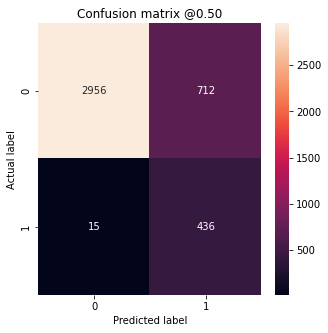

In [ ]:
model_evaluate = model.evaluate(test_ds)
for name_metric, value_evaluate in zip(model.metrics_names, model_evaluate):
  print(name_metric, ': ', value_evaluate)

plot_confution_matrix(label_test, predict_test)

Tidak berlangganan diprediksi tidak berlangganan (True Negatives):  2896
Tidak berlangganan diprediksi berlangganan (False Positives):  772
Berlangganan diprediksi tidak berlangganan (False Negatives):  12
Berlangganan diprediksi berlangganan (True Positives):  439
Total:  451


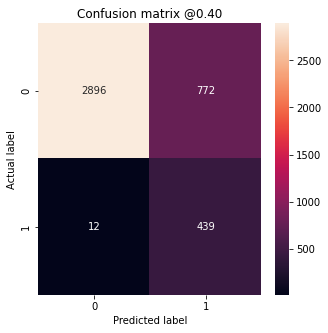

In [ ]:
plot_confution_matrix(label_test, predict_test, p=0.4)

In [ ]:
dataset_test.sort_values(by=["target"], ascending=True).head()

,age,job,marital,education,housing,loan,month,duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
0,30,blue-collar,married,basic.9y,yes,no,may,487,-1.8,92.893,-46.2,1.313,5099.1,0
2660,43,blue-collar,married,basic.9y,yes,no,may,545,-1.8,92.893,-46.2,1.344,5099.1,0
2662,33,management,married,university.degree,no,no,aug,191,1.4,93.444,-36.1,4.965,5228.1,0
2663,40,admin.,single,high.school,no,no,jun,97,1.4,94.465,-41.8,4.967,5228.1,0
2664,58,blue-collar,married,basic.4y,yes,no,jul,86,1.4,93.918,-42.7,4.960,5228.1,0


##Simulation

In [ ]:
sample = {
    'age': 30,
    'job': 'blue-collar',
    'marital': 'married',
    'education': 'basic.9y',
    'housing': 'yes',
    'loan': 'no',
    'month': 'may',
    'duration': 487,
    "emp.var.rate":-1.8,
    "cons.price.idx":92.893, 
    "cons.conf.idx":-46.2, 
    "euribor3m":1.313, 
    "nr.employed":5099.1
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    f"Probabilitas untuk berlangganan deposito berjangka adalah {round(100 * predictions[0][0], 2)} % "
    f"untuk setuju"
)

Probabilitas untuk berlangganan deposito berjangka adalah 70.75 % untuk setuju


In [ ]:
predictions

array([[0.70747805]], dtype=float32)